In [2]:
from astropy.io import fits
from astropy import wcs
import os
import numpy as np
from ants import cvMe, fitsPlay
from scipy.ndimage.interpolation import zoom

#import sharpener
#from sharpener import mirlib
import lib, shutil
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, LogLocator
from matplotlib import transforms as mtransforms
from matplotlib.ticker import LogFormatter 
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm

conv = cvMe.convert()
fp = fitsPlay.fitsplay()



#home = '/home/'
home = '/Users/'

rootDir = home+'maccagni/Projects/MFS/FornaxA/MUSE/'
cubeDir = rootDir+'cubes/'

GAL = 'FornaxE'
RUN = '_4750-6800-v100'

resDir= cubeDir+'results/'+GAL+RUN+'/mycubes/'

resPlots = cubeDir+'results/'+GAL+RUN+'/myplots/'



print '''\t+---------+\n\t Inputs loaded\n\t+---------+''' 

Setup logger with lib.setup_logger()
	+---------+
	 Inputs loaded
	+---------+


In [6]:
#----------------------#
# Convert to VRAD
#----------------------#

oIIIVrad= resDir+'OIIICubeVrad.fits'

f = fits.open(oIIIVrad)
hh = f[0].header
dd = f[0].data

vrotMin = 1760-250.
vrotMax = 1760+250.

vel = ((np.linspace(1, dd.shape[0], dd.shape[0]) - hh['CRPIX3']) * hh['CDELT3'] + hh['CRVAL3']) /1e3

indMin = (np.abs(vel - vrotMin)).argmin()
indMax = (np.abs(vel - vrotMax)).argmin()+1

print indMax

print '''\t+---------+\n\t fits loaded\n\t+---------+'''     

40
	+---------+
	 fits loaded
	+---------+


In [7]:
#----------------------#
# Filter Cubes
#----------------------#

cubeSNR = resDir+'OIIICubeVradSNR.fits'
mom0Name = resDir+'OIII_mom0RotNoFit.fits'
mom1Name = resDir+'OIII_mom1RotNoFit.fits'

cubeSNR = resDir+'OIIICubeVradSNRRot.fits'
cubeSNRBroad = resDir+'OIIICubeVradSNRBroad.fits'
noiseName = resDir+'OIIICubeNoise.fits'


SNR= 3.
SNRVel= 5.

#measure noise along spaxel in empty region
f = fits.open(oIIIVrad)
hh = f[0].header
dd = f[0].data

indexCubeA = 0
indexCubeB = 24
indexCubeC = 50
indexCubeD = 66

lineCube = resDir+'LineCube.fits'
f = fits.open(lineCube)
lines = f[0].data

newDD = dd.copy()*0.0
newDD = np.multiply(newDD,0.0)

newBB = dd.copy()*0.0
newBB = np.multiply(newBB,0.0)

mom0 = np.zeros([newDD.shape[1],newDD.shape[2]])
mom1 = np.zeros([newDD.shape[1],newDD.shape[2]])


noiseCube = dd.copy()*0.0
noiseCube = np.multiply(noiseCube,0.0)

#create AllSpectra datacube
for j in xrange(0,dd.shape[1]):
    for i in xrange(0,dd.shape[2]):    
        
        noiseA = np.std(lines[indexCubeA:indexCubeB,j,i])
        noiseB = np.std(lines[indexCubeC:indexCubeD,j,i])
        noise = np.mean([noiseA,noiseB])
        
        maximum = np.max(dd[indexCubeB:indexCubeC,j,i])
        SNRLim = SNR*noise 
        SNRLimVel = SNRVel*noise 
              
        if maximum > SNRLim: 

            arr = dd[indMin:indMax,j,i] 

            arr[arr<=SNRLim] = 0.0
            newDD[indMin:indMax,j,i] = arr         
            
            barr = dd[:,j,i]
            barr[indMin:indMax] = 0
            newBB[:,j,i] = barr
     
            mom0[j,i] = np.sum(arr)
            noiseCube[:,j,i] = SNRLim
            
        else:
            newDD[:,j,i] = np.nan

        if maximum > SNRLimVel:   
            
            arr = dd[indMin:indMax,j,i]
            
            arr[arr<=SNRLimVel] = 0.0
            
            #peak mom1
        #    mom1[j,i] = np.divide(np.sum(np.multiply(np.max(arr[indexCubeB:indexCubeC]),vel[np.argmax(arr[indexCubeB:indexCubeC])]))
        #                          ,np.sum(arr[indexCubeB:indexCubeC]))
            
            mom1[j,i] = np.divide(np.sum(np.multiply(arr,vel[indMin:indMax])),np.sum(arr))

            
hh['RESTFREQ'] = 5.987741757660128e13
hh['SPECSYS'] = 'BARYCENT'
hh['CRVAL3'] =  hh['CRVAL3']-1760e3

print hh['CRVAL3']
fits.writeto(cubeSNR,newDD,hh,overwrite=True)

fits.writeto(cubeSNRBroad,newBB,hh,overwrite=True)

fits.writeto(noiseName,noiseCube,hh,overwrite=True)

if 'NAXIS3' in hh:
    del hh['NAXIS3']
if 'CRVAL3' in hh:
    hh['FREQ'] = hh['CRVAL3']
    del hh['CRVAL3']
if 'CDELT3' in hh:
    del hh['CDELT3']
if 'CRPIX3' in hh: 
    del hh['CRPIX3']
if 'CTYPE3' in hh:        
    del hh['CTYPE3']  
if 'CROTA3' in hh:
    del hh['CROTA3']
if 'CUNIT3' in hh:
    del hh['CUNIT3'] 
    
    
mom1[mom1==0.0] = np.nan    
mom0[mom0==0.0] = np.nan    

    
fits.writeto(mom0Name,mom0,hh,overwrite=True)
fits.writeto(mom1Name,mom1,hh,overwrite=True)


print '''\t+---------+\n\t fits saved\n\t+---------+'''     

/Users/maccagni/programs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in divide


-2321447.47944
	+---------+
	 fits saved
	+---------+


In [8]:
from lmfit import Model
from lmfit.models import GaussianModel


mod = GaussianModel()


cubeSNR = resDir+'OIIICubeVradSNRRot.fits'

mom0Name = resDir+'OIII_mom0Rot.fits'
mom1Name = resDir+'OIII_mom1Rot.fits'

f = fits.open(cubeSNR)
hh = f[0].header
dd = f[0].data

#SNR
#vel = ((np.linspace(1, dd.shape[0], dd.shape[0]) - hh['CRPIX3']) * hh['CDELT3'] + hh['CRVAL3']) /1e3 - 1760
#SNROT
vel = ((np.linspace(1, dd.shape[0], dd.shape[0]) - hh['CRPIX3']) * hh['CDELT3'] + hh['CRVAL3']) /1e3 


mom0 = np.zeros([dd.shape[1],dd.shape[2]])
mom1 = np.zeros([dd.shape[1],dd.shape[2]])
#create AllSpectra datacube
for j in xrange(0,dd.shape[1]):
    for i in xrange(0,dd.shape[2]):

        
        y = dd[:,j,i]
        
        
        if np.sum(y)>0:

            pars = mod.guess(y, x=vel)
            result = mod.fit(y, pars, x=vel)
            

            fitRes = result.params.valuesdict()
            
            mom0[j,i] = fitRes['amplitude']
            mom1[j,i] = fitRes['center']
            #plt.plot(vel, y, 'bo')
            
            plt.step(vel, y, where='mid', color='black', linestyle='-')

            #plt.plot(vel, result.init_fit, 'k--', label='initial fit')
            plt.plot(vel, result.best_fit, 'r-', label='best fit')
            res = y-result.best_fit
            plt.step(vel, res, 'g-', label='residual')
            
            plt.legend(loc='best')
            #plt.show()
            
            plt.savefig(resPlots+'OIII/'+str(i)+'_'+str(j)+'_snrRot')
            plt.close()
        else:
            pass
        
        
mom1[mom1==0.0] = np.nan    
mom0[mom0==0.0] = np.nan    

    
fits.writeto(mom0Name,mom0,hh,overwrite=True)
fits.writeto(mom1Name,mom1,hh,overwrite=True)        
        
print '''\t+---------+\n\t fits saved\n\t+---------+'''     

	+---------+
	 fits saved
	+---------+


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 101
    # variables        = 3
    chi-square         = 3.40495392
    reduced chi-square = 0.03474443
    Akaike info crit   = -336.378800
    Bayesian info crit = -328.533439
[[Variables]]
    sigma:      0.75581925 +/- 0.03117432 (4.12%) (init = 0.8)
    center:     0.22305333 +/- 0.03117435 (13.98%) (init = 0.2)
    amplitude:  4.67849590 +/- 0.16711502 (3.57%) (init = 6.688222)
    fwhm:       1.77981829 +/- 0.07340992 (4.12%) == '2.3548200*sigma'
    height:     2.46943949 +/- 0.08820799 (3.57%) == '0.3989423*amplitude/max(2.22044604925e-16, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(sigma, amplitude) =  0.577
8.4
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 101
    # variables        = 3
    chi-square         = 3.40495392
    reduc

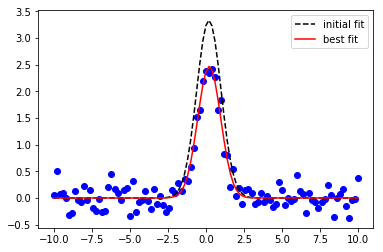

In [8]:
from lmfit import Model

def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x-cen)**2 / wid)

gmodel = Model(gaussian)

x_eval = np.linspace(-10, 10, 101)
y = gaussian(x_eval, 2.33, 0.21, 1.51) + np.random.normal(0, 0.2, x_eval.size)

result = gmodel.fit(y, x=x_eval, cen=0.0, amp=2, wid=2.0)

maxVal = np.max(y)
halfY1 = y[0:np.argmax(y)]
halfY2 = y[np.argmax(y):]

halfVal = maxVal/2.
cenVal = x_eval[np.argmax(y)]

idxLft = np.abs(halfY1 - halfVal).argmin()
idxRgt = np.abs(halfY2 - halfVal).argmin()



mod = GaussianModel()

pars = mod.guess(y, x=x_eval)
out = mod.fit(y, pars, x=x_eval)

print(out.fit_report(min_correl=0.25))

sigma = np.abs(x_eval[idxRgt] -x_eval[idxLft])


print sigma
print(result.fit_report())

plt.plot(x_eval, y, 'bo')
plt.plot(x_eval, out.init_fit, 'k--', label='initial fit')
plt.plot(x_eval, out.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()


In [79]:
cubeSNR_mir = resDir+'OIIICubeVradSNRRot.mir'

mom0Mir = resDir+'OIII_mom0Rot.mir'
mom1Mir = resDir+'OIII_mom1Rot.mir'

mom0Fits = resDir+'OIII_mom0RotMir.fits'
mom1Fits = resDir+'OIII_mom1RotMir.fits'

if os.path.exists(cubeSNR_mir):
    shutil.rmtree(cubeSNR_mir)
if os.path.exists(mom0Mir):
    shutil.rmtree(mom0Mir)
    
if os.path.exists(mom1Mir):
    shutil.rmtree(mom1Mir)
 
    
if os.path.exists(mom0Fits):
    os.remove(mom0Fits)
    
if os.path.exists(mom1Fits):
    os.remove(mom1Fits)

pyfits = lib.miriad('fits')
pyfits.op = 'xyin'
pyfits.in_ = cubeSNR
pyfits.out = cubeSNR_mir
pyfits.go()

mom = lib.miriad('moment')
mom.in_ = cubeSNR_mir
mom.out = mom0Mir
mom.mom = '0'
mom.go()

mom.in_ = cubeSNR_mir
mom.out = mom1Mir
mom.mom = '1'
mom.go()

pyfits = lib.miriad('fits')
pyfits.op = 'xyout'
pyfits.in_ = mom0Mir
pyfits.out = mom0Fits
pyfits.go()

pyfits = lib.miriad('fits')
pyfits.op = 'xyout'
pyfits.in_ = mom1Mir
pyfits.out = mom1Fits
pyfits.go()

print '''\t+---------+\n\t miriad is done\n\t+---------+'''     

	+---------+
	 miriad is done
	+---------+


In [17]:
#----------------------#
# Convert to VRAD
#----------------------#

oIIIVrad= resDir+'HbetaCubeVrad.fits'

f = fits.open(oIIIVrad)
hh = f[0].header
dd = f[0].data

vrotMin = 1760-250.
vrotMax = 1760+250.

vel = ((np.linspace(1, dd.shape[0], dd.shape[0]) - hh['CRPIX3']) * hh['CDELT3'] + hh['CRVAL3']) /1e3 

indMin = (np.abs(vel - vrotMin)).argmin()
indMax = (np.abs(vel - vrotMax)).argmin()+1

print indMax

print '''\t+---------+\n\t fits loaded\n\t+---------+'''     

16
	+---------+
	 fits loaded
	+---------+


In [18]:
#----------------------#
# Filter Cubes
#----------------------#

cubeSNR = resDir+'HbetaCubeVradSNRRot.fits'
mom0Name = resDir+'Hbeta_mom0Rot.fits'
mom1Name = resDir+'Hbeta_mom1Rot.fits'

cubeSNR = resDir+'HbetaCubeVradSNRRot.fits'
cubeSNRBroad = resDir+'HbetaCubeVradSNRBroad.fits'
noiseName = resDir+'HbetaCubeNoise.fits'


SNR= 3.
SNRVel= 5.

#measure noise along spaxel in empty region
f = fits.open(oIIIVrad)
hh = f[0].header
dd = f[0].data

indexCubeA = 0
indexCubeB = 2
indexCubeC = 17
indexCubeD = 22

lineCube = resDir+'LineCube.fits'
f = fits.open(lineCube)
lines = f[0].data

newDD = dd.copy()*0.0
newDD = np.multiply(newDD,0.0)

newBB = dd.copy()*0.0
newBB = np.multiply(newBB,0.0)

mom0 = np.zeros([newDD.shape[1],newDD.shape[2]])
mom1 = np.zeros([newDD.shape[1],newDD.shape[2]])


noiseCube = dd.copy()*0.0
noiseCube = np.multiply(noiseCube,0.0)

#create AllSpectra datacube
for j in xrange(0,dd.shape[1]):
    for i in xrange(0,dd.shape[2]):    
        
        noiseA = np.std(lines[indexCubeA:indexCubeB,j,i])
        noiseB = np.std(lines[indexCubeC:indexCubeD,j,i])
        noise = np.mean([noiseA,noiseB])
        
        maximum = np.max(dd[indexCubeB:indexCubeC,j,i])
        SNRLim = SNR*noise 
        SNRLimVel = SNRVel*noise 
              
        if maximum > SNRLim: 

            arr = dd[indMin:indMax,j,i] 

            arr[arr<=SNRLim] = 0.0
            newDD[indMin:indMax,j,i] = arr         
            
            barr = dd[:,j,i]
            barr[indMin:indMax] = 0
            newBB[:,j,i] = barr
     
            mom0[j,i] = np.sum(arr)
            noiseCube[:,j,i] = SNRLim
            
        else:
            newDD[:,j,i] = np.nan

        if maximum > SNRLimVel:   
            
            arr = dd[indMin:indMax,j,i]
            
            arr[arr<=SNRLimVel] = 0.0
            
            #peak mom1
        #    mom1[j,i] = np.divide(np.sum(np.multiply(np.max(arr[indexCubeB:indexCubeC]),vel[np.argmax(arr[indexCubeB:indexCubeC])]))
        #                          ,np.sum(arr[indexCubeB:indexCubeC]))
            
            mom1[j,i] = np.divide(np.sum(np.multiply(arr,vel[indMin:indMax])),np.sum(arr))

            
hh['RESTFREQ'] = 5.987741757660128e13
hh['SPECSYS'] = 'BARYCENT'
hh['CRVAL3'] =  hh['CRVAL3']-1760e3

print hh['CRVAL3']
fits.writeto(cubeSNR,newDD,hh,overwrite=True)

fits.writeto(cubeSNRBroad,newBB,hh,overwrite=True)

fits.writeto(noiseName,noiseCube,hh,overwrite=True)

if 'NAXIS3' in hh:
    del hh['NAXIS3']
if 'CRVAL3' in hh:
    hh['FREQ'] = hh['CRVAL3']
    del hh['CRVAL3']
if 'CDELT3' in hh:
    del hh['CDELT3']
if 'CRPIX3' in hh: 
    del hh['CRPIX3']
if 'CTYPE3' in hh:        
    del hh['CTYPE3']  
if 'CROTA3' in hh:
    del hh['CROTA3']
if 'CUNIT3' in hh:
    del hh['CUNIT3'] 
    
    
mom1[mom1==0.0] = np.nan    
mom0[mom0==0.0] = np.nan    

    
fits.writeto(mom0Name,mom0,hh,overwrite=True)
fits.writeto(mom1Name,mom1,hh,overwrite=True)


print '''\t+---------+\n\t fits saved\n\t+---------+'''     

/Users/maccagni/programs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in divide


-698092.416167
	+---------+
	 fits saved
	+---------+


In [15]:
#----------------------#
# Convert to VRAD
#----------------------#

oIIIVrad= resDir+'OICubeVrad.fits'

f = fits.open(oIIIVrad)
hh = f[0].header
dd = f[0].data

vrotMin = 1760-250.
vrotMax = 1760+250.

vel = ((np.linspace(1, dd.shape[0], dd.shape[0]) - hh['CRPIX3']) * hh['CDELT3'] + hh['CRVAL3']) /1e3 

indMin = (np.abs(vel - vrotMin)).argmin()
indMax = (np.abs(vel - vrotMax)).argmin()+1

print indMax

print '''\t+---------+\n\t fits loaded\n\t+---------+'''     

16
	+---------+
	 fits loaded
	+---------+


In [16]:
#----------------------#
# Filter Cubes
#----------------------#

cubeSNR = resDir+'OICubeVradSNRRot.fits'
mom0Name = resDir+'OI_mom0Rot.fits'
mom1Name = resDir+'OI_mom1Rot.fits'

cubeSNR = resDir+'OICubeVradSNRRot.fits'
cubeSNRBroad = resDir+'OICubeVradSNRBroad.fits'
noiseName = resDir+'OICubeNoise.fits'


SNR= 3.
SNRVel= 5.

#measure noise along spaxel in empty region
f = fits.open(oIIIVrad)
hh = f[0].header
dd = f[0].data

indexCubeA = 0
indexCubeB = 2
indexCubeC = 25
indexCubeD = 61

lineCube = resDir+'LineCube.fits'
f = fits.open(lineCube)
lines = f[0].data

newDD = dd.copy()*0.0
newDD = np.multiply(newDD,0.0)

newBB = dd.copy()*0.0
newBB = np.multiply(newBB,0.0)

mom0 = np.zeros([newDD.shape[1],newDD.shape[2]])
mom1 = np.zeros([newDD.shape[1],newDD.shape[2]])


noiseCube = dd.copy()*0.0
noiseCube = np.multiply(noiseCube,0.0)

#create AllSpectra datacube
for j in xrange(0,dd.shape[1]):
    for i in xrange(0,dd.shape[2]):    
        
        noiseA = np.std(lines[indexCubeA:indexCubeB,j,i])
        noiseB = np.std(lines[indexCubeC:indexCubeD,j,i])
        noise = np.mean([noiseA,noiseB])
        
        maximum = np.max(dd[indexCubeB:indexCubeC,j,i])
        SNRLim = SNR*noise 
        SNRLimVel = SNRVel*noise 
              
        if maximum > SNRLim: 

            arr = dd[indMin:indMax,j,i] 

            arr[arr<=SNRLim] = 0.0
            newDD[indMin:indMax,j,i] = arr         
            
            barr = dd[:,j,i]
            barr[indMin:indMax] = 0
            newBB[:,j,i] = barr
     
            mom0[j,i] = np.sum(arr)
            noiseCube[:,j,i] = SNRLim
            
        else:
            newDD[:,j,i] = np.nan

        if maximum > SNRLimVel:   
            
            arr = dd[indMin:indMax,j,i]
            
            arr[arr<=SNRLimVel] = 0.0
            
            #peak mom1
        #    mom1[j,i] = np.divide(np.sum(np.multiply(np.max(arr[indexCubeB:indexCubeC]),vel[np.argmax(arr[indexCubeB:indexCubeC])]))
        #                          ,np.sum(arr[indexCubeB:indexCubeC]))
            
            mom1[j,i] = np.divide(np.sum(np.multiply(arr,vel[indMin:indMax])),np.sum(arr))

            
hh['RESTFREQ'] = 5.987741757660128e13
hh['SPECSYS'] = 'BARYCENT'
hh['CRVAL3'] =  hh['CRVAL3']-1760e3

print hh['CRVAL3']
fits.writeto(cubeSNR,newDD,hh,overwrite=True)

fits.writeto(cubeSNRBroad,newBB,hh,overwrite=True)

fits.writeto(noiseName,noiseCube,hh,overwrite=True)

if 'NAXIS3' in hh:
    del hh['NAXIS3']
if 'CRVAL3' in hh:
    hh['FREQ'] = hh['CRVAL3']
    del hh['CRVAL3']
if 'CDELT3' in hh:
    del hh['CDELT3']
if 'CRPIX3' in hh: 
    del hh['CRPIX3']
if 'CTYPE3' in hh:        
    del hh['CTYPE3']  
if 'CROTA3' in hh:
    del hh['CROTA3']
if 'CUNIT3' in hh:
    del hh['CUNIT3'] 
    
    
mom1[mom1==0.0] = np.nan    
mom0[mom0==0.0] = np.nan    

    
fits.writeto(mom0Name,mom0,hh,overwrite=True)
fits.writeto(mom1Name,mom1,hh,overwrite=True)


print '''\t+---------+\n\t fits saved\n\t+---------+'''     

/Users/maccagni/programs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in divide


-723285.826101
	+---------+
	 fits saved
	+---------+
